#  Apache Spark Basics

## Part a) Basic Operations on Resilient Distributed Dataset (RDD)

In [1]:
#Import required libraries
import pyspark
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from pyspark.sql.functions import datediff,col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when
from pyspark_dist_explore import hist

#Initialize sparkcontext
sc = SparkContext()


22/07/03 19:18:05 WARN Utils: Your hostname, Sruthys-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.103 instead (on interface en0)
22/07/03 19:18:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/03 19:18:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/03 19:18:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
#Initialize 2 lists of words

a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

In [3]:
#Creating rdd objects for the lists
rdd_a=sc.parallelize(a)
rdd_a.collect()

#adding a label with each word in list
rdda = rdd_a.map(lambda x: (x,'a'))


In [4]:
#Creating rdd object 
rdd_b = sc.parallelize(b)
rddb = rdd_b.map(lambda x: (x,'b'))

Performing rightOuterJoin and fullOuterJoin operations between a and b. 

In [5]:
sorted(rdda.fullOuterJoin(rddb).collect())

[('apache', (None, 'b')),
 ('class', ('a', None)),
 ('context', ('a', None)),
 ('create', ('a', None)),
 ('lambda', (None, 'b')),
 ('operation', (None, 'b')),
 ('parallel', (None, 'b')),
 ('partition', (None, 'b')),
 ('python', ('a', None)),
 ('rdd', ('a', None)),
 ('scala', (None, 'b')),
 ('spark', ('a', None))]

We see that fullouterjoin returns a list having each word in both the lists along with whether they occur in the corresponding the lists. If they occur the label we had given earlier is present, else None. We see that none of the words occur in both the lists

In [6]:
sorted(rddb.rightOuterJoin(rdda).collect())

[('class', (None, 'a')),
 ('context', (None, 'a')),
 ('create', (None, 'a')),
 ('python', (None, 'a')),
 ('rdd', (None, 'a')),
 ('spark', (None, 'a'))]

In rightouterjoin, it returns a list having the words in the rdd_a only. It shows that none of those words occur in the other rdd as it returns none. And they all are member of list a as it returns that label

Using map and reduce functions to count how many times the character "s" appears in all a and
b.

We define a function that counts the occurrence of letter s in each word in the list. And that function is passed with the map function of each rdd. Then we combine the outputs of both rdd maps and perform reduce operation to count the total number s characters. 

In [7]:
def Func(x):
    return (x.count('s'))

count_a = rdd_a.map(Func)
count_b = rdd_b.map(Func)

In [8]:
# The occurence of s in each word in rdd_a . Total occurence - 3
count_a.collect()

[1, 0, 0, 0, 0, 2]

In [9]:
# The occurence of s in each word in rdd_a . Total occurence - 1
count_b.collect()

[0, 0, 1, 0, 0, 0]

In [10]:
#Union function combines both the count lists
reduce_rdd = count_a.union(count_b)

#we reduce function yields the sum of input characters
reduce_rdd.reduce(lambda x, y : x + y)

4

Using aggregate function to count how many times the character "s" appears in all a and b.

We first combine the rdd's and then map the count in each word and create data frame with the words and count of 's' in each word as columns

In [11]:
#Combines the lists
full = (rdd_a.union(rdd_b))
full.collect()

['spark',
 'rdd',
 'python',
 'context',
 'create',
 'class',
 'operation',
 'apache',
 'scala',
 'lambda',
 'parallel',
 'partition']

In [12]:
#Function which gives each word and the number of 's' characters in each word
def Func_new(x):
    return (x,x.count('s'))

#map function
count_full = full.map(Func_new)
count_full.collect()

[('spark', 1),
 ('rdd', 0),
 ('python', 0),
 ('context', 0),
 ('create', 0),
 ('class', 2),
 ('operation', 0),
 ('apache', 0),
 ('scala', 1),
 ('lambda', 0),
 ('parallel', 0),
 ('partition', 0)]

In [13]:

# creating dataframe from the output of map function

spark = SparkSession.builder.appName("groupbyagg").getOrCreate()
df = spark.createDataFrame(data=count_full, schema=["word","count"])
df.collect()

[Row(word='spark', count=1),
 Row(word='rdd', count=0),
 Row(word='python', count=0),
 Row(word='context', count=0),
 Row(word='create', count=0),
 Row(word='class', count=2),
 Row(word='operation', count=0),
 Row(word='apache', count=0),
 Row(word='scala', count=1),
 Row(word='lambda', count=0),
 Row(word='parallel', count=0),
 Row(word='partition', count=0)]

In [14]:
#Finding the count of s characters in all the lists using aggregate on the count column
df.agg({'count':'sum'}).show()

+----------+
|sum(count)|
+----------+
|         4|
+----------+



### Part b) Basic Operations on DataFrames

In [15]:
#Creating data frame from json file
df_students = spark.read.json("Downloads/students.json")
df_students.printSchema()
df_students.show()

root
 |-- course: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- points: long (nullable = true)
 |-- s_id: long (nullable = true)

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978

1. Replace the null value(s) in column points by the mean of all points

In [16]:
#First fill null with 0
df_students.na.fill(0,"points")
df_students.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

In [17]:
# finding the mean of the points column
df_mean = df_students.agg({'points':'avg'}).collect()
df_mean[0][0]

11.736842105263158

In [18]:
#Filling the null value with mean
df_students = df_students.fillna(value = df_mean[0][0], subset=['points'] )
df_students.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

2. Replace the null value(s) in column dob and column last name by "unknown" and "--" respectively. 

In [19]:
df_students = df_students.fillna(value ="unknown", subset=['dob'])
df_students = df_students.fillna(value ="--", subset=['last_name'])
df_students.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

In [20]:
df_students

DataFrame[course: string, dob: string, first_name: string, last_name: string, points: bigint, s_id: bigint]

3. Convert all dates to dd-mm-yyyy format

In [21]:
# Converting all date of MMMM d,yyyy to date format 
df_students1 = df_students.select( col("dob"),to_date(col("dob"),"MMMM d, yyyy").alias("date"))
df_students1.show()

+------------------+----------+
|               dob|      date|
+------------------+----------+
|  October 14, 1983|1983-10-14|
|September 26, 1980|1980-09-26|
|     June 12, 1982|1982-06-12|
|     April 5, 1987|1987-04-05|
|  November 1, 1978|1978-11-01|
|  17 February 1981|      null|
|    1 January 1984|      null|
|  January 13, 1978|1978-01-13|
|  26 December 1989|      null|
|  30 December 1987|      null|
|     June 12, 1975|1975-06-12|
|      July 2, 1985|1985-07-02|
|     July 22, 1980|1980-07-22|
|   7 February 1986|      null|
|      May 18, 1987|1987-05-18|
|   August 10, 1984|1984-08-10|
|  16 December 1990|      null|
|           unknown|      null|
|      7 March 1980|      null|
|      June 2, 1985|1985-06-02|
+------------------+----------+



In [22]:
#Converting the dates of format d MMMM yyyy to date format
df_students2 = df_students.select(col("dob"),to_date(col("dob"),"d MMMM yyyy").alias("date_new")) 
df_students2.show()

#Now I combine both the dates got to geta dataframe having original dobs, and the converted ones
combine = df_students1.join(df_students2, on=["dob"])
combine.show()

+------------------+----------+
|               dob|  date_new|
+------------------+----------+
|  October 14, 1983|      null|
|September 26, 1980|      null|
|     June 12, 1982|      null|
|     April 5, 1987|      null|
|  November 1, 1978|      null|
|  17 February 1981|1981-02-17|
|    1 January 1984|1984-01-01|
|  January 13, 1978|      null|
|  26 December 1989|1989-12-26|
|  30 December 1987|1987-12-30|
|     June 12, 1975|      null|
|      July 2, 1985|      null|
|     July 22, 1980|      null|
|   7 February 1986|1986-02-07|
|      May 18, 1987|      null|
|   August 10, 1984|      null|
|  16 December 1990|1990-12-16|
|           unknown|      null|
|      7 March 1980|1980-03-07|
|      June 2, 1985|      null|
+------------------+----------+

+------------------+----------+----------+
|               dob|      date|  date_new|
+------------------+----------+----------+
|  October 14, 1983|1983-10-14|      null|
|September 26, 1980|1980-09-26|      null|
|     June 12, 1

In [23]:
#Combining the converted dobs to one column such that they replace the null values 
combine = combine.withColumn("dob_new",f.coalesce("date","date_new"))


In [24]:
#dropping unwanted columns
df_students = df_students.join(combine, on=["dob"]).drop("date","date_new")
#Replacing null values 
df_students = df_students.fillna(value ="unknown", subset=['dob_new'])

df_students.show()

+------------------+------------------+----------+---------+------+----+----------+
|               dob|            course|first_name|last_name|points|s_id|   dob_new|
+------------------+------------------+----------+---------+------+----+----------+
|  October 14, 1983|Humanities and Art|      Alan|      Joe|    10|   1|1983-10-14|
|September 26, 1980|  Computer Science|    Martin|  Genberg|    17|   2|1980-09-26|
|     June 12, 1982|    Graphic Design|     Athur|   Watson|    16|   3|1982-06-12|
|     April 5, 1987|    Graphic Design|  Anabelle|  Sanberg|    12|   4|1987-04-05|
|  November 1, 1978|        Psychology|      Kira| Schommer|    11|   5|1978-11-01|
|  17 February 1981|          Business| Christian|   Kiriam|    10|   6|1981-02-17|
|    1 January 1984|  Machine Learning|   Barbara|  Ballard|    14|   7|1984-01-01|
|  January 13, 1978|     Deep Learning|      John|       --|    10|   8|1978-01-13|
|  26 December 1989|  Machine Learning|    Marcus|   Carson|    15|   9|1989

In [25]:
#For type date, fillna doesnt work, hence replacing it to 0000-00-00
df_students = df_students.fillna(value ="unknown", subset=["dob_new"])
for t in df_students.dtypes:
     if t[1] == 'date':
            df_students = df_students.withColumn(t[0], f.coalesce(t[0], f.lit('0000-00-00')))
   
    

df_students.show()

+------------------+------------------+----------+---------+------+----+----------+
|               dob|            course|first_name|last_name|points|s_id|   dob_new|
+------------------+------------------+----------+---------+------+----+----------+
|  October 14, 1983|Humanities and Art|      Alan|      Joe|    10|   1|1983-10-14|
|September 26, 1980|  Computer Science|    Martin|  Genberg|    17|   2|1980-09-26|
|     June 12, 1982|    Graphic Design|     Athur|   Watson|    16|   3|1982-06-12|
|     April 5, 1987|    Graphic Design|  Anabelle|  Sanberg|    12|   4|1987-04-05|
|  November 1, 1978|        Psychology|      Kira| Schommer|    11|   5|1978-11-01|
|  17 February 1981|          Business| Christian|   Kiriam|    10|   6|1981-02-17|
|    1 January 1984|  Machine Learning|   Barbara|  Ballard|    14|   7|1984-01-01|
|  January 13, 1978|     Deep Learning|      John|       --|    10|   8|1978-01-13|
|  26 December 1989|  Machine Learning|    Marcus|   Carson|    15|   9|1989

In [26]:
#Changing the format to the required dd-mm-yyy
combine_n = df_students.select(*[col("dob_new"), 
    date_format(col("dob_new"), "dd-MM-yyyy").alias("date_format")] )
combine_n = combine_n.fillna(value ="unknown", subset=['dob_new','date_format'])
combine_n.show()


+----------+-----------+
|   dob_new|date_format|
+----------+-----------+
|1983-10-14| 14-10-1983|
|1980-09-26| 26-09-1980|
|1982-06-12| 12-06-1982|
|1987-04-05| 05-04-1987|
|1978-11-01| 01-11-1978|
|1981-02-17| 17-02-1981|
|1984-01-01| 01-01-1984|
|1978-01-13| 13-01-1978|
|1989-12-26| 26-12-1989|
|1987-12-30| 30-12-1987|
|1975-06-12| 12-06-1975|
|1985-07-02| 02-07-1985|
|1980-07-22| 22-07-1980|
|1986-02-07| 07-02-1986|
|1987-05-18| 18-05-1987|
|1984-08-10| 10-08-1984|
|1990-12-16| 16-12-1990|
|0000-00-00|    unknown|
|1980-03-07| 07-03-1980|
|1985-06-02| 02-06-1985|
+----------+-----------+



In [27]:
#Adding the required date format column to original dataframe.
combine_n = combine_n.fillna(value ="unknown", subset=['dob_new'])
combine_n.show()

df_students = df_students.join(combine_n, on=["dob_new"])
df_students.show()

+----------+-----------+
|   dob_new|date_format|
+----------+-----------+
|1983-10-14| 14-10-1983|
|1980-09-26| 26-09-1980|
|1982-06-12| 12-06-1982|
|1987-04-05| 05-04-1987|
|1978-11-01| 01-11-1978|
|1981-02-17| 17-02-1981|
|1984-01-01| 01-01-1984|
|1978-01-13| 13-01-1978|
|1989-12-26| 26-12-1989|
|1987-12-30| 30-12-1987|
|1975-06-12| 12-06-1975|
|1985-07-02| 02-07-1985|
|1980-07-22| 22-07-1980|
|1986-02-07| 07-02-1986|
|1987-05-18| 18-05-1987|
|1984-08-10| 10-08-1984|
|1990-12-16| 16-12-1990|
|0000-00-00|    unknown|
|1980-03-07| 07-03-1980|
|1985-06-02| 02-06-1985|
+----------+-----------+

+----------+------------------+------------------+----------+---------+------+----+-----------+
|   dob_new|               dob|            course|first_name|last_name|points|s_id|date_format|
+----------+------------------+------------------+----------+---------+------+----+-----------+
|0000-00-00|           unknown|    Data Analytics|   Bridget|    Twain|     6|  18|    unknown|
|1975-06-12|   

4. Insert a new column age and calculate the current age of all students. 

In [28]:

#Adding the current date in a column
df2 = df_students.withColumn("current", f.current_date())


df2.show()



+----------+------------------+------------------+----------+---------+------+----+-----------+----------+
|   dob_new|               dob|            course|first_name|last_name|points|s_id|date_format|   current|
+----------+------------------+------------------+----------+---------+------+----+-----------+----------+
|0000-00-00|           unknown|    Data Analytics|   Bridget|    Twain|     6|  18|    unknown|2022-07-03|
|1975-06-12|     June 12, 1975|    Data Analytics|     Holly| Schwartz|    12|  11| 12-06-1975|2022-07-03|
|1978-01-13|  January 13, 1978|     Deep Learning|      John|       --|    10|   8| 13-01-1978|2022-07-03|
|1978-11-01|  November 1, 1978|        Psychology|      Kira| Schommer|    11|   5| 01-11-1978|2022-07-03|
|1980-03-07|      7 March 1980|          Business|   Darlene|    Mills|    19|  19| 07-03-1980|2022-07-03|
|1980-07-22|     July 22, 1980|  Computer Science|     Irene|  Bradley|    13|  13| 22-07-1980|2022-07-03|
|1980-09-26|September 26, 1980|  Comp

In [29]:
# Finding age by getting the difference in years between dob and current date

df_f = df2.withColumn("age", datediff(col("current"),col("dob_new"))/365.25)
#converting to integer
new_df = df_f.withColumn("age", df_f["age"].cast(IntegerType()))

In [30]:
#Dropping unwanted columns
df_new2 = new_df.drop("dob_new","current")
df_new2.show()

+------------------+------------------+----------+---------+------+----+-----------+----+
|               dob|            course|first_name|last_name|points|s_id|date_format| age|
+------------------+------------------+----------+---------+------+----+-----------+----+
|           unknown|    Data Analytics|   Bridget|    Twain|     6|  18|    unknown|null|
|     June 12, 1975|    Data Analytics|     Holly| Schwartz|    12|  11| 12-06-1975|  47|
|  January 13, 1978|     Deep Learning|      John|       --|    10|   8| 13-01-1978|  44|
|  November 1, 1978|        Psychology|      Kira| Schommer|    11|   5| 01-11-1978|  43|
|      7 March 1980|          Business|   Darlene|    Mills|    19|  19| 07-03-1980|  42|
|     July 22, 1980|  Computer Science|     Irene|  Bradley|    13|  13| 22-07-1980|  41|
|September 26, 1980|  Computer Science|    Martin|  Genberg|    17|   2| 26-09-1980|  41|
|  17 February 1981|          Business| Christian|   Kiriam|    10|   6| 17-02-1981|  41|
|     June

Let’s consider granting some points for good performed students in the class. For each student,
if his point is larger than 1 standard deviation of all points, then we update his current point to
20, which is the maximum.

In [31]:
#Finding mean and standard deviation of the column points
std = df_new2.agg({'points': 'stddev' })
mean = df_new2.agg({'points':'mean'})

std.show()
mean.show()


+-----------------+
|   stddev(points)|
+-----------------+
|3.246050231475656|
+-----------------+

+-----------+
|avg(points)|
+-----------+
|       11.7|
+-----------+



In [32]:
# The points having value greater than 1 std is asssigned as 20.
df3 = df_new2.withColumn("points", when(df_new2.points >= 15,20) \
      .otherwise(df_new2.points))
df3.show()

+------------------+------------------+----------+---------+------+----+-----------+----+
|               dob|            course|first_name|last_name|points|s_id|date_format| age|
+------------------+------------------+----------+---------+------+----+-----------+----+
|           unknown|    Data Analytics|   Bridget|    Twain|     6|  18|    unknown|null|
|     June 12, 1975|    Data Analytics|     Holly| Schwartz|    12|  11| 12-06-1975|  47|
|  January 13, 1978|     Deep Learning|      John|       --|    10|   8| 13-01-1978|  44|
|  November 1, 1978|        Psychology|      Kira| Schommer|    11|   5| 01-11-1978|  43|
|      7 March 1980|          Business|   Darlene|    Mills|    20|  19| 07-03-1980|  42|
|     July 22, 1980|  Computer Science|     Irene|  Bradley|    13|  13| 22-07-1980|  41|
|September 26, 1980|  Computer Science|    Martin|  Genberg|    20|   2| 26-09-1980|  41|
|  17 February 1981|          Business| Christian|   Kiriam|    10|   6| 17-02-1981|  41|
|     June

Create a histogram on the new points created in the task 5

(array([2., 0., 6., 3., 3., 2., 0., 0., 0., 4.]),
 array([ 6. ,  7.4,  8.8, 10.2, 11.6, 13. , 14.4, 15.8, 17.2, 18.6, 20. ]),
 <BarContainer object of 10 artists>)

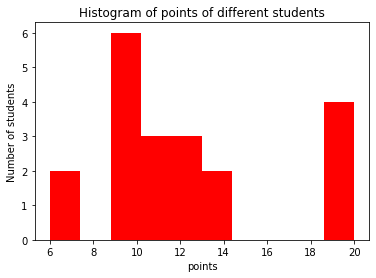

In [33]:

fig, ax = plt.subplots()
ax.set_xlabel("points")
ax.set_ylabel("Number of students")
ax.set_title("Histogram of points of different students")
hist(ax, df3.select('points'), bins = 10, color=['red'])

#Histogram shows that 6 students got around 10 points.

In [34]:
#Final dataframe obtained

df3.orderBy("s_id").show(truncate=False)

+------------------+------------------+----------+---------+------+----+-----------+----+
|dob               |course            |first_name|last_name|points|s_id|date_format|age |
+------------------+------------------+----------+---------+------+----+-----------+----+
|October 14, 1983  |Humanities and Art|Alan      |Joe      |10    |1   |14-10-1983 |38  |
|September 26, 1980|Computer Science  |Martin    |Genberg  |20    |2   |26-09-1980 |41  |
|June 12, 1982     |Graphic Design    |Athur     |Watson   |20    |3   |12-06-1982 |40  |
|April 5, 1987     |Graphic Design    |Anabelle  |Sanberg  |12    |4   |05-04-1987 |35  |
|November 1, 1978  |Psychology        |Kira      |Schommer |11    |5   |01-11-1978 |43  |
|17 February 1981  |Business          |Christian |Kiriam   |10    |6   |17-02-1981 |41  |
|1 January 1984    |Machine Learning  |Barbara   |Ballard  |14    |7   |01-01-1984 |38  |
|January 13, 1978  |Deep Learning     |John      |--       |10    |8   |13-01-1978 |44  |
|26 Decemb

References

https://sparkbyexamples.com/pyspark/pyspark-orderby-and-sort-explained/
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yscale.html
https://sparkbyexamples.com/pyspark/pyspark-update-a-column-with-value/#:~:text=You%20can%20do%20update%20a,new%20Dataframe%20with%20updated%20values.
https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame
https://stackoverflow.com/questions/63813253/how-to-add-extra-column-with-current-date-in-spark-dataframe
https://stackoverflow.com/questions/71889053/pyspark-how-do-i-replace-null-values-based-on-datatype-of-the-column
https://sparkbyexamples.com/pyspark/pyspark-sql-date-and-timestamp-functions/
https://stackoverflow.com/questions/58310246/how-to-concatenate-to-a-null-column-in-pyspark-dataframe
https://stackoverflow.com/questions/40368877/creating-pyspark-dataframe-column-that-coalesces-two-other-columns-why-am-i-get
https://stackoverflow.com/questions/42853778/add-a-column-from-another-dataframe
https://sparkbyexamples.com/pyspark/pyspark-to_date-convert-string-to-date-format/
https://netflixsub.com/how-to-replace-null-values-with-mean-in-pyspark-dataframe/
https://stackoverflow.com/questions/30756939/results-of-reduce-and-count-differ-in-pyspark
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.rightOuterJoin.html
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-pyspark-rdd-operations/
https://sparkbyexamples.com/pyspark/pyspark-parallelize-create-rdd/